## Test final du modèle choisi : EfficientNetB1

* les fonctions utilisé :

In [18]:
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow import keras 
import tensorflow.keras.applications as kapps

#
# Paramétres par défaut
#
NB_ECHANTILLONS=-1
NB_CLASSES = 27 
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.15
BATCH_SIZE = 32
EPOCHSS = [5, 10] # [epochs en mode freezed, epochs en mode unfreezed]
OPTIMIZERS = [keras.optimizers.Adam(lr=1e-3),
             keras.optimizers.Adam(lr=1e-4)]

def read_X(nb=NB_ECHANTILLONS):
    """
    Lecture de nb entrées et ajout des colonnes 'imgpath' et 'class'
    """
    def image_path(row, subdir="image_train"):
        f = "image_%d_product_%d.jpg" % (row.imageid, row.productid) 
        ff = os.path.join(os.getcwd(), "images", subdir, f)
        return ff if os.path.isfile(ff) else None
    X = pd.read_csv("X_train_update.csv")[:nb]
    y = pd.read_csv("Y_train_CVw08PX.csv").drop("Unnamed: 0", axis=1)["prdtypecode"][:nb]
    X['imgpath'] = X.apply(lambda x: image_path(x), axis=1)
    X['class'] = y.astype(str) # Needed by generator
    return X

def image_data_generator(X_train,
                         X_test,
                         img_height,
                         img_width,
                         preprocessing_function,
                         batch_size,
                         validation_split):
    """
    Générateurs d'images, elle sont augmentées pour train et validation
    Quand ils existent on utilise les preprocesseurs fournis par les modèles et
    non le paramètre rescale=1./255. Certains modèles comme EfficientNet incluent
    le preprocessing dans le modèle lui-même.
    Le générateur de test n'est pas augmenté, ni mélangé (pour garder les indices
    de classes dans l'ordre initial)
    """
    datagenerator = keras.preprocessing.image.ImageDataGenerator(
        validation_split = validation_split,
        preprocessing_function = preprocessing_function,
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 0.1,
        brightness_range=[0.9, 1.1],
        horizontal_flip = True
    )
    traingen = datagenerator.flow_from_dataframe(
        subset = 'training', dataframe=X_train, x_col="imgpath", y_col="class",
        class_mode="sparse", target_size=(img_height, img_width), batch_size=batch_size
    )
    valgen = datagenerator.flow_from_dataframe(
        subset='validation', dataframe=X_train, x_col="imgpath", y_col="class",
        class_mode="sparse", target_size=(img_height, img_width), batch_size=batch_size
    )
    testgen = keras.preprocessing.image.ImageDataGenerator( 
        preprocessing_function = preprocessing_function).flow_from_dataframe(
        dataframe=X_test, x_col="imgpath", y_col="class",
        class_mode=None, target_size=(img_height, img_width), batch_size=batch_size,
        shuffle = False
    )

    return traingen, valgen, testgen

def plot_history(title, history):
    """
    Affiche les évolution par epoch de la perte et de l'accuracy
    """
    plt.figure(figsize=(15,3))
    plt.subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title}: Loss by epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='right')
    plt.subplot(122)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title}: Accuracy by epoch')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='right')
    plt.show()

def test_model(name,
               inputshape,
               pprocfunc,
               basemodel,
               topmodel,
               basetrainable,
               epochss=EPOCHSS,
               optimizers=OPTIMIZERS):
    """
    Evalue un modèle en fonction des paramètres, le score F1-w est affiché
    """
    time0 = time.time()
    print(f"+++ {name}: Lit les échantillons")
    X = read_X()
    X = shuffle(X)
    X_train, X_test, y_train, y_test = train_test_split(X, X['class'],
                                            test_size = TEST_SPLIT,
                                            random_state = 123)
    print(f"+++ {name}: Crée les générateurs d'images")
    traingen, valgen, testgen = image_data_generator(X_train, X_test,
                                                     inputshape[0], inputshape[1],
                                                     pprocfunc,
                                                     BATCH_SIZE,
                                                     VALIDATION_SPLIT) 
    print(f"+++ {name}: Freeze des layers de base et entrainement...")
    for layer in basemodel.layers:
        layer.trainable = False
    model = keras.models.Sequential([basemodel, topmodel])
    model.compile(optimizer=optimizers[0],
              loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=1,
                                      restore_best_weights=True, verbose=1)
    ]
    history = model.fit(traingen, epochs=epochss[0],
                    steps_per_epoch = traingen.n//traingen.batch_size,
                    validation_data = valgen,
                    validation_steps = valgen.n//valgen.batch_size,
                    callbacks=callbacks)
    plot_history(f"{name} freezed", history)
    #
    print(f"+++ {name}: Defreeze les {basetrainable} derniers layers et entrainement...")
    if 0 < epochss[-1]:
        bestweights = f"{name}.bestweights.hdf5"
        if os.path.isfile(bestweights):
            os.remove(bestweights)
        for layer in basemodel.layers[-basetrainable:]:
            if not isinstance(layer, keras.layers.BatchNormalization):
                layer.trainable = True
        model.compile(optimizer=optimizers[-1],
                    loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
                                          restore_best_weights=True,
                                          verbose=1),
            keras.callbacks.ModelCheckpoint(filepath=bestweights,
                                        save_weights_only=True, save_best_only=True,
                                        monitor='val_loss', mode='min')
        ]
        history = model.fit(traingen, epochs=epochss[-1],
                    steps_per_epoch = traingen.n//traingen.batch_size,
                    validation_data = valgen,
                    validation_steps = valgen.n//valgen.batch_size,
                    callbacks=callbacks)
        model.load_weights(bestweights)
        
        plot_history(f"{name} unfreezed", history)
    #
    print(f"+++ {name}: Prédit les classes du jeu de test...")
    softmaxout = model.predict(testgen, verbose = 1)
    labels = dict((v,k) for k,v in (traingen.class_indices).items())
    assert len(labels) == NB_CLASSES
    y_pred = [labels[i] for i in np.argmax(softmaxout, axis=1)]
    score = round(f1_score(y_test, y_pred, average = "weighted"), 4)
    duration = int(time.time()-time0)
    print(f"\n+++ {name}: Weighted F1 score = {score}  ({duration} sec)\n")
    model.save(f'{name}.h5')

    return score


* Le modèle choisi (efficientnetb1 ) sera testé avec : 
- batch_size= 32, 64 et les tailles des images (240,240) et (480,480)

* Entrainement :

In [19]:


topmodel_A = [
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(NB_CLASSES, activation='softmax')
    ]

topmodel_B = [
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(NB_CLASSES, activation='softmax')
    ]

topmodel_C = [
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.BatchNormalization(trainable = True,axis=1),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.BatchNormalization(trainable = True,axis=1),
        keras.layers.Dense(NB_CLASSES,activation='softmax')
    ]


def model_efficientnetb1():
    inputshape = (240, 240, 3) # Dépend du Bx
    pprocfunc = None # Inclus dans le modèle qui attend des données [..255]
    basemodel = tf.keras.applications.EfficientNetB1(input_shape = inputshape,
                                              include_top = False,
                                              # drop_connect_rate=0.4,
                                              weights = 'imagenet')
    topmodel = keras.models.Sequential(topmodel_C)
    return test_model("EfficientNetB1", inputshape, pprocfunc,
                      basemodel, topmodel, basetrainable=20)



+++ EfficientNetB1: Lit les échantillons
+++ EfficientNetB1: Crée les générateurs d'images
Found 57743 validated image filenames belonging to 27 classes.
Found 10189 validated image filenames belonging to 27 classes.
Found 16983 validated image filenames.
+++ EfficientNetB1: Freeze des layers de base et entrainement...
Epoch 1/5
1804/1804 [==============================] - 4260s 2s/step - loss: 1.7894 - accuracy: 0.4837 - val_loss: 1.4623 - val_accuracy: 0.5610
Epoch 2/5
1804/1804 [==============================] - 4218s 2s/step - loss: 1.5098 - accuracy: 0.5480 - val_loss: 1.3679 - val_accuracy: 0.5883
Epoch 3/5
1804/1804 [==============================] - 4218s 2s/step - loss: 1.4164 - accuracy: 0.5710 - val_loss: 1.3548 - val_accuracy: 0.5944
Epoch 4/5
1804/1804 [==============================] - 4228s 2s/step - loss: 1.3669 - accuracy: 0.5848 - val_loss: 1.2833 - val_accuracy: 0.6097
Epoch 5/5
1804/1804 [==============================] - 4223s 2s/step - loss: 1.3127 - accuracy: 0.5

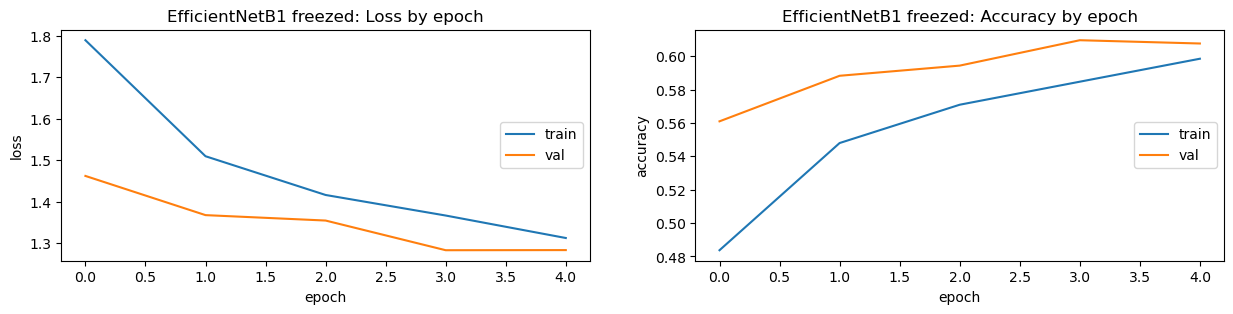

+++ EfficientNetB1: Defreeze les 20 derniers layers et entrainement...
Epoch 1/10
1804/1804 [==============================] - 4813s 3s/step - loss: 1.4403 - accuracy: 0.5655 - val_loss: 1.3285 - val_accuracy: 0.5970
Epoch 2/10
1804/1804 [==============================] - 4827s 3s/step - loss: 1.2974 - accuracy: 0.6061 - val_loss: 1.3048 - val_accuracy: 0.6127
Epoch 3/10
1804/1804 [==============================] - 4779s 3s/step - loss: 1.2230 - accuracy: 0.6262 - val_loss: 1.2391 - val_accuracy: 0.6206
Epoch 4/10
1804/1804 [==============================] - 4819s 3s/step - loss: 1.1526 - accuracy: 0.6432 - val_loss: 1.2426 - val_accuracy: 0.6232
Epoch 5/10
1804/1804 [==============================] - 6068s 3s/step - loss: 1.0979 - accuracy: 0.6583 - val_loss: 1.2124 - val_accuracy: 0.6375
Epoch 6/10
1804/1804 [==============================] - 6349s 4s/step - loss: 1.0359 - accuracy: 0.6755 - val_loss: 1.1979 - val_accuracy: 0.6468
Epoch 7/10
1804/1804 [==============================]

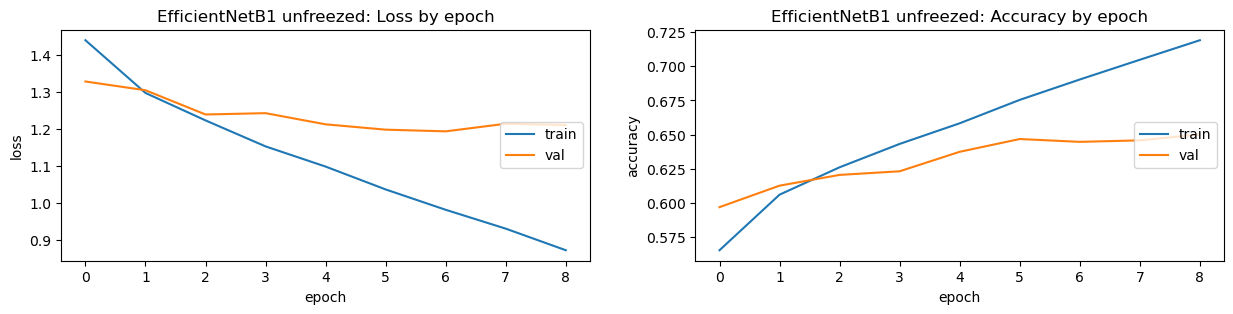

+++ EfficientNetB1: Prédit les classes du jeu de test...
531/531 [==============================] - 1323s 2s/step

+++ EfficientNetB1: Weighted F1 score = 0.6377  (69552 sec)



TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [7]:
# BATCH_SIZE = 32, inputshape = (240, 240, 3)

BATCH_SIZE = 32
model_efficientnetb1()

+++ EfficientNetB1: Lit les échantillons
+++ EfficientNetB1: Crée les générateurs d'images
Found 57743 validated image filenames belonging to 27 classes.
Found 10189 validated image filenames belonging to 27 classes.
Found 16983 validated image filenames.
+++ EfficientNetB1: Freeze des layers de base et entrainement...
Epoch 1/5
1804/1804 [==============================] - 7040s 4s/step - loss: 1.7550 - accuracy: 0.4946 - val_loss: 1.4262 - val_accuracy: 0.5701
Epoch 2/5
1804/1804 [==============================] - 7380s 4s/step - loss: 1.4732 - accuracy: 0.5541 - val_loss: 1.3303 - val_accuracy: 0.5925
Epoch 3/5
1804/1804 [==============================] - 6644s 4s/step - loss: 1.3867 - accuracy: 0.5777 - val_loss: 1.3188 - val_accuracy: 0.6020
Epoch 4/5
1804/1804 [==============================] - 6725s 4s/step - loss: 1.3283 - accuracy: 0.5947 - val_loss: 1.2715 - val_accuracy: 0.6143
Epoch 5/5
1804/1804 [==============================] - 6635s 4s/step - loss: 1.2849 - accuracy: 0.6

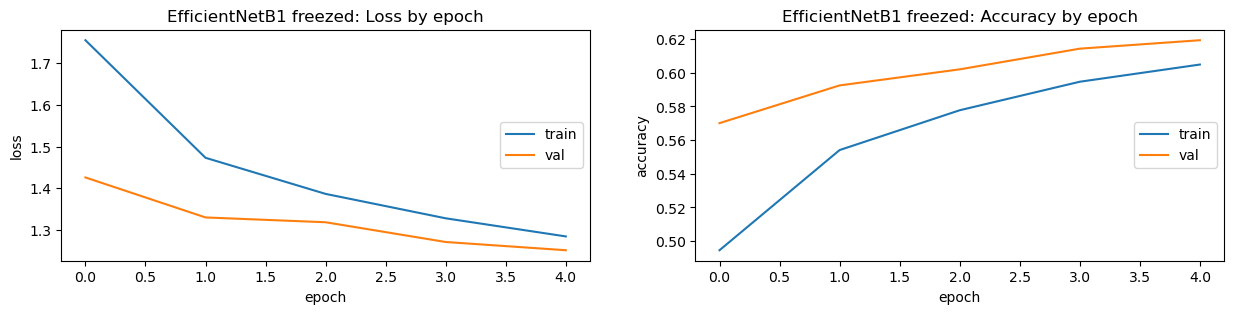

+++ EfficientNetB1: Defreeze les 20 derniers layers et entrainement...
Epoch 1/10
1804/1804 [==============================] - 7466s 4s/step - loss: 1.3749 - accuracy: 0.5817 - val_loss: 1.3024 - val_accuracy: 0.6015
Epoch 2/10
1804/1804 [==============================] - 7445s 4s/step - loss: 1.2361 - accuracy: 0.6194 - val_loss: 1.2853 - val_accuracy: 0.6125
Epoch 3/10
1804/1804 [==============================] - 8146s 5s/step - loss: 1.1675 - accuracy: 0.6412 - val_loss: 1.2483 - val_accuracy: 0.6291
Epoch 4/10
1804/1804 [==============================] - 9619s 5s/step - loss: 1.1060 - accuracy: 0.6568 - val_loss: 1.2294 - val_accuracy: 0.6264
Epoch 5/10
1804/1804 [==============================] - 7423s 4s/step - loss: 1.0463 - accuracy: 0.6722 - val_loss: 1.1880 - val_accuracy: 0.6423
Epoch 6/10
1804/1804 [==============================] - 8685s 5s/step - loss: 0.9939 - accuracy: 0.6850 - val_loss: 1.2467 - val_accuracy: 0.6347
Epoch 7/10
1804/1804 [==============================]

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [15]:
# BATCH_SIZE = 32, inputshape = (300, 300, 3)

model_efficientnetb1()

In [20]:
# BATCH_SIZE = 64, inputshape = (240, 240, 3)

model_efficientnetb1()

+++ EfficientNetB1: Lit les échantillons
+++ EfficientNetB1: Crée les générateurs d'images
Found 57743 validated image filenames belonging to 27 classes.
Found 10189 validated image filenames belonging to 27 classes.
Found 16983 validated image filenames.
+++ EfficientNetB1: Freeze des layers de base et entrainement...
Epoch 1/5
902/902 [==============================] - 4205s 5s/step - loss: 1.7728 - accuracy: 0.4898 - val_loss: 1.4080 - val_accuracy: 0.5815
Epoch 2/5
902/902 [==============================] - 4195s 5s/step - loss: 1.4674 - accuracy: 0.5603 - val_loss: 1.3356 - val_accuracy: 0.5988
Epoch 3/5
902/902 [==============================] - ETA: 0s - loss: 1.3701 - accuracy: 0.5824

KeyboardInterrupt: 